# 1. Preparation of the dataset

Getting an extended dataset:

1. Get new data from https://www.bluebikes.com/system-data
2. Download the trip zip files for each month of 2019
3. Append them in one dataframe
4. Download current station data from website

All datasets used are provided.

## Libraries
Import the required libraries for later use.

In [12]:


import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
import math
import time
import operator
from datetime import datetime, timedelta
import numpy as np
import requests
import urllib.parse
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions, ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Blues8, Oranges8

# For Google Maps script
import json
import urllib
import requests

#Machine Learning
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

## Meta settings

In [13]:
# For Google Maps script
API_KEY = ''
GOOGLE_MAPS_DATA_FILE = "./datasets/google_api_data.json"

# Data provided
TRIP_DATA_PATH = './datasets/boston_2019.csv'
WEATHER_DATA_PATH = './datasets/weather_hourly_boston.csv'

# Station data from Blue Bikes website
STATION_DATA_PATH = './datasets/current_bluebikes_stations.csv'

# Load all csv for the different months in 2019 from Boston Bikes System Data
TRIP_DATA_WEBSITE_JANUARY = './datasets/csv/201901-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_FEBRUARY = './datasets/csv/201902-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_MARCH = './datasets/csv/201903-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_APRIL = './datasets/csv/201904-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_MAY = './datasets/csv/201905-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_JUNE = './datasets/csv/201906-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_JULY = './datasets/csv/201907-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_AUGUST = './datasets/csv/201908-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_SEPTEMBER = './datasets/csv/201909-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_OCTOBER = './datasets/csv/201910-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_NOVEMBER = './datasets/csv//201911-bluebikes-tripdata.csv'
TRIP_DATA_WEBSITE_DECEMBER = './datasets/csv/201912-bluebikes-tripdata.csv'


# Assign datatypes for each dataframe
TRIP_DTYPES = {
    'start_time': 'datetime64',
    'end_time': 'datetime64',
    'start_station_id': 'int64',
    'end_station_id': 'int',
    'start_station_name': 'str',
    'end_station_name': 'str',
    'bike_id': 'int64',
    'user_type': 'str',
}

TRIP_WEBSITE_DTYPES = {
    'trip_duration': 'int64',
    'start_time': 'datetime64',
    'stop_time': 'datetime64',
    'start_station_id': 'int64',
    'start_station_name': 'str',
    'start_station_lat': 'float64',
    'start_station_lng': 'float64',
    'end_station_id': 'int',
    'end_station_name': 'str',
    'end_station_lat': 'float64',
    'end_station_lng': 'float64',
    'bike_id': 'int64',
    'user_type': 'str',
    'birth_year': 'int64',
    'gender': 'int64',
    'user_type_id': 'int64'
}

WEATHER_DTYPES = {
    'max_temp': 'float64',
    'min_temp': 'float64',
    'precip': 'int64'
}

STATION_DTYPES = {
    'station_id_string': 'str',
    'station_name': 'str',
    'station_lat': 'float64',
    'station_lng': 'float64',
    'district': 'str',
    'total_docks': 'int64',
    'deployment_year': 'int64',
    'station_id': 'int64',
    'public': 'str',
    'station_id': 'int64'
}


## Loading the data
Here we load the data into our notebook. 

We haves 3 types of data:

1. Trip_data: data on individual trips, each represented by one record, such as time or station info
2. Weather_data: data on temperature and rain for each hour
3. Station_data: data for each station (e.g. number of docks or deployment year)

In [14]:
# Read all  provided csv data for trips, weather and stations into dataframes
trip_data = pd.read_csv(TRIP_DATA_PATH)
weather_data = pd.read_csv(WEATHER_DATA_PATH)


We also use station data from the Boston Bikes website, as it contains more information about each station that may be useful later, such as the number of docks or the year of deployment.

In [15]:
# Read all the stations csv data from the Blue Bikes website
station_data = pd.read_csv(STATION_DATA_PATH)

We use the trip data from the Boston Bikes website because it contains slightly more information about each trip, such as gender or year of birth.

We load the trip data for each month and then concat them into one dataframe.

In [16]:
# Read all csv trip data for each month into dataframes
trip_data_website_january = pd.read_csv(TRIP_DATA_WEBSITE_JANUARY)
trip_data_website_february = pd.read_csv(TRIP_DATA_WEBSITE_FEBRUARY)
trip_data_website_march = pd.read_csv(TRIP_DATA_WEBSITE_MARCH)
trip_data_website_april = pd.read_csv(TRIP_DATA_WEBSITE_APRIL)
trip_data_website_may = pd.read_csv(TRIP_DATA_WEBSITE_MAY)
trip_data_website_june = pd.read_csv(TRIP_DATA_WEBSITE_JUNE)
trip_data_website_july = pd.read_csv(TRIP_DATA_WEBSITE_JULY)
trip_data_website_august = pd.read_csv(TRIP_DATA_WEBSITE_AUGUST)
trip_data_website_september = pd.read_csv(TRIP_DATA_WEBSITE_SEPTEMBER)
trip_data_website_october = pd.read_csv(TRIP_DATA_WEBSITE_OCTOBER)
trip_data_website_november = pd.read_csv(TRIP_DATA_WEBSITE_NOVEMBER)
trip_data_website_december = pd.read_csv(TRIP_DATA_WEBSITE_DECEMBER)

In [17]:
# Concat datasets for each month from website into one dataframe
trip_data_website = pd.concat([trip_data_website_january, trip_data_website_february, trip_data_website_march, trip_data_website_april, trip_data_website_june, trip_data_website_july, trip_data_website_august, trip_data_website_september, trip_data_website_october, trip_data_website_november, trip_data_website_december], ignore_index=True)

## Modify the data
### Trip data
First, we rename the columns of the trip data from the website to appropriate names. Since there are only two types of users (subscribers and customers), we binarize them into their own column. This will make clustering easier later. Finally, we assign the dtypes.

In [18]:
# Rename headers of website trip data
trip_data_website = trip_data_website.rename(columns={'tripduration':'trip_duration', 'starttime':'start_time', 'stoptime':'stop_time', 'start station id':'start_station_id', 'start station name':'start_station_name', 'start station latitude':'start_station_lat', 'start station longitude':'start_station_lng', 'end station id':'end_station_id', 'end station name':'end_station_name', 'end station latitude':'end_station_lat', 'end station longitude':'end_station_lng', 'bikeid':'bike_id', 'usertype':'user_type', 'birth year':'birth_year', 'gender':'gender'})

# Binarize the user type into own column (Subscriber = 1, Customer = 0) for both trip_data and trip_data_website
print(trip_data_website['user_type'].unique())
trip_data_website['user_type_id'] = trip_data_website.apply(lambda row: 1 if row.user_type == 'Subscriber' else 0, axis=1)

['Subscriber' 'Customer']


In [19]:
# Assign dtype to trip data website
trip_data_website = trip_data_website.astype(TRIP_WEBSITE_DTYPES)

### Weather data
The weather data provided ranges from 2015 to 2022. Here we only need the data for 2019, so we filter the data by year and sort it by date.

In [26]:
# Set date_time to pandas datetime
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

In [21]:
# Filter weather data for 2019
weather_data = weather_data[weather_data['date_time']<pd.to_datetime('2020-01-01 00:00:00')]
weather_data = weather_data[weather_data['date_time']>=pd.to_datetime('2019-01-01 00:00:00')]

# Sort weather data by date
weather_data = weather_data.sort_values(by='date_time')

For the weather data, we had to make some assumptions on how to interpret the data.

**Assumption 1**: For the duplicates, we assume that the weather changes throughout the hour. However, since we have no information on which part of the hour the weather changes, we take the first record of each duplicate.

**Assumption 2**: The time at which the ride begins is critical to the weather, since this is when the client decides to use the bike.

**Assumption 3**: Since some hours are missing in weather_data, we assume that the weather has not changed during this time. Therefore, we will fill these hours with the previous weather conditions. 

In [22]:
# Drop duplicates and keep first record
weather_data = weather_data.drop_duplicates(subset='date_time', keep='first')

# Generate all hours for 2019 and merge with weather data
hours_2019 = pd.DataFrame(pd.date_range(pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2019-12-31 23:00:00'), freq='H'), columns=['date_time'])
weather_all_hours = pd.merge(how='outer', left=weather_data, right=hours_2019, on='date_time').sort_values(by='date_time').reset_index(drop=True)

# Set date_time as index for dataframe
weather_all_hours = weather_all_hours.set_index('date_time')

# Fill missing values with forward fill and dtypes with backward fill
weather_all_hours = weather_all_hours.fillna(method='ffill')
weather_all_hours = weather_all_hours.fillna(method='bfill').astype(WEATHER_DTYPES)

Lastly, we will merge the weather data into the trip data, so each trip has the weather associated with it.

In [23]:
trip_data_website = pd.merge_asof(trip_data_website.sort_values('start_time'), weather_all_hours.sort_index(), left_on='start_time', right_index=True, direction='backward')

In [24]:
trip_data_website.head(1)

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_lat,start_station_lng,end_station_id,end_station_name,end_station_lat,end_station_lng,bike_id,user_type,birth_year,gender,user_type_id,max_temp,min_temp,precip
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1,1,5.6,5.6,1


### Station data
We can see that the header of station_data is not yet correct, the right values are in the first row. Therefore,  we need to set the first row as the header, delete the first record and reset the index. Then we will rename the columns to better fitting names.

In [ ]:
station_data.head(2)

In [ ]:
# Set header to first row values
station_data.columns = station_data.iloc[0]

# Remove first row by slicing
station_data = station_data[1:]


In [ ]:
# Reset index
station_data.reset_index(drop=True, inplace=True)

In [ ]:
# Rename headers
station_data = station_data.rename(columns={'Number': 'station_id_string', 'Name': 'station_name', 'District': 'district', 'Total docks': 'total_docks', 'Deployment Year': 'deployment_year', 'Public': 'public', 'Latitude':'station_lat', 'Longitude':'station_lng'})

In [ ]:
station_data.head(1)

Now we check the station data for missing values.

In [ ]:
# Check for NaN in station_data
station_data[station_data.isnull().any(axis=1)]

In [ ]:
# Check for NaN in each column
print('There are ' + str(station_data.isnull().sum().sum()) + ' missing values in total.')
print('There are ' + str(station_data['station_id_string'].isnull().sum()) + ' missing values in station id string.')
print('There are ' + str(station_data['station_name'].isnull().sum()) + ' missing values in station name.')
print('There are ' + str(station_data['station_lat'].isnull().sum()) + ' missing values in station lat.')
print('There are ' + str(station_data['station_lng'].isnull().sum()) + ' missing values in station lng.')
print('There are ' + str(station_data['district'].isnull().sum()) + ' missing values in district.')
print('There are ' + str(station_data['public'].isnull().sum()) + ' missing values in public.')
print('There are ' + str(station_data['total_docks'].isnull().sum()) + ' missing values in total docks.')
print('There are ' + str(station_data['deployment_year'].isnull().sum()) + ' missing values in deployment year.')

We can see that there are 9 missing values in total. 

Four of them in the district column. Therefore, we check where they appear and fill them with the correct value after a manual Google Maps search.



In [ ]:
# Fill missing values with the correct district
station_data.loc[7].district='Somerville'
station_data.loc[236].district='Cambridge'
station_data.loc[262].district='Malden'
station_data.loc[302].district='Salem'

In [ ]:
# Check district NaN
print('There are ' + str(station_data['district'].isnull().sum()) + ' missing values in district.')

For the deployment year, we can see that 3 of the 5 stations have a "Temp Winter Station" in their name. We assume that they are only used in winter each year and therefore have the current year as their year of deployment - in this case 2022.

In [ ]:
# Fill missing deployment years
station_data.loc[7].deployment_year=2022
station_data.loc[83].deployment_year=2022
station_data.loc[401].deployment_year=2022

In [ ]:
# Check deployment NaN
print('There are ' + str(station_data['deployment_year'].isnull().sum()) + ' missing values in deployment year.')

For the missing 2 values, we have no indication of when the year of deployment was. After searching the trip data for 'Boylston St at Charles St' and 'John Ahern Field at Kennedy-Longfellow School', we can see that there are no trips associated with either station.

In [ ]:
# For both stations there are no results for the starting and ending station
print(trip_data_website[trip_data_website['start_station_name'].str.contains('Boylston St at Charles St')])
print(trip_data_website[trip_data_website['end_station_name'].str.contains('Boylston St at Charles St')])
print(trip_data_website[trip_data_website['start_station_name'].str.contains('John Ahern Field at Kennedy-Longfellow School')])
print(trip_data_website[trip_data_website['end_station_name'].str.contains('John Ahern Field at Kennedy-Longfellow School')])

Therefore, we delete both stations from station_data and reset the index.

In [ ]:
# Drop Boylston St at Charles St (index=65) from station_data
station_data = station_data.drop([65])

# Drop John Ahern Field at Kennedy-Longfellow School (index=236) from station_data
station_data = station_data.drop([236])

# Reset index
station_data.reset_index(drop=True, inplace=True)

As shown below, there are now no missing values.

In [ ]:
# Check for NaN
station_data[station_data.isnull().any(axis=1)]

We can see that there are more stations in station_data than stations are appearing in trip_data. Therefore, we extract the stations from trip_data and merge them with the information available in the station data.

In [ ]:
# Check amount of stations in station_data and trip_data
print('There are ' + str(len(station_data['station_name'].unique())) + ' stations in the station data.')
print('There are ' + str(len(trip_data_website['start_station_id'].unique())) + ' start stations in trip data.')
print('There are ' + str(len(trip_data_website['end_station_id'].unique())) + ' end stations in trip data.')

In [ ]:
# Get all unique start and end stations
start_stations = trip_data_website.drop_duplicates(subset="start_station_id", keep="first")[["start_station_id","start_station_name", "start_station_lat", "start_station_lng"]].sort_values(by="start_station_id").reset_index(drop=True)
end_stations = trip_data_website.drop_duplicates(subset="end_station_id", keep="first")[["end_station_id","end_station_name", "end_station_lat", "end_station_lng"]].sort_values(by="end_station_id").reset_index(drop=True)

# Merge all unique start and end stations into one dataframe
all_stations = start_stations.merge(end_stations, left_on='start_station_id', right_on="end_station_id", how='outer', suffixes=['', '_'], indicator=True)

In [ ]:
# Check for NaN in all_stations
all_stations[all_stations.isnull().any(axis=1)]

We can see that there are 5 stations with missing values - 2 start stations and 3 end stations. 

This means that the first two stations **only** appear as start stations and **never** appear as end stations, and the last 3 stations **only** appear as end stations and **never** appear as start stations, which explains the results above.

The samples where no values for latitude and longitude are given are problematic, here ***MTL-ECO5.1-01*** (start), ***8D QC Station 02*** (end) and ***MTL-ECO4-01*** (end).

We will now check in which of the trips the stations occur.

In [ ]:
# # Check all trips for starting station: MTL-ECO5.1-01
# for index, row in trip_data_website.iterrows():
#     if 'MTL-ECO5.1-01' in row['start_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

In [ ]:
# # Check all trips for ending station: 8D QC Station 02
# for index, row in trip_data_website.iterrows():
#     if '8D QC Station 02' in row['end_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

In [ ]:
# # Check all trips for ending station: MTL-ECO4-01
# for index, row in trip_data_website.iterrows():
#     if 'MTL-ECO4-01' in row['end_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

For ***MTL-ECO5.1-01*** (start) and ***MTL-ECO4-01*** (end) there is one trip with the ID ***994366***. 
For ***8D QC Station 02*** (end) there is a trip from ***8D QC Station 01*** (start) with the ID ***50153***.

We can also check with the stations dataset which of the stations above are appearing. We can neither find ***8D QC Station 02*** nor ***MTL-ECO4-01***. We can find ***MTL-ECO5.1-01*** and ***8D QC Station 01*** as listed stations.

For ***8D QC Station 01*** we have latitude and longitude values, but if there is only one occurrence in trip_data, it is not so important, so we check it as well.

In [ ]:
# # Check all trips for starting station: 8D QC Station 01
# for index, row in trip_data_website.iterrows():
#     if '8D QC Station 01' in row['start_station_name']:
#         print(index, row['start_station_name'], row['end_station_name'])

Since there is only one trip associated with each of the stations (***8D QC Station 01***, ***8D QC Station 02***, ***MTL-ECO5.1-01***, and ***MTL-ECO4-01***), they do not seem important to the scope of the task. Therefore, the trips are deleted from the trip data.



In [ ]:
# Drop trips by id 
trip_data_website = trip_data_website.drop([50153])
trip_data_website = trip_data_website.drop([994366])

# Reset index
trip_data_website.reset_index(drop=True, inplace=True)


Next, we remove the stations listed above from the all_stations dataframe.

In [ ]:
# Drop stations by id (8D QC Station 01 id=202, MTL-ECO5.1-01 id=278, 8D QC Station 02 id=339, MTL-ECO4-01 id=340)
all_stations = all_stations.drop([202])
all_stations = all_stations.drop([278])
all_stations = all_stations.drop([339])
all_stations = all_stations.drop([340])

# Reset index
all_stations.reset_index(drop=True, inplace=True)

In [ ]:
# Check for NaN
all_stations[all_stations.isnull().any(axis=1)]

As there is one more end station than start station, we will use the end stations as the basis for our station data. 

We can omit the columns *start_station_id*, *start_station_name*, *start_station_lat* and *start_station_lng* because they provide the same information as the end station values. Then we rename the columns to appropriate names.

In [ ]:
#  We will drop the columns start_station_id, start_station_name, start_station_lat, start_station_lng as they are not needed
all_stations = all_stations.drop(['start_station_id', 'start_station_name', 'start_station_lat', 'start_station_lng', '_merge' ], axis=1)

In [ ]:
# Rename columns
all_stations = all_stations.rename(columns={'end_station_id': 'station_id', 'end_station_name': 'station_name', 'end_station_lat': 'station_lat', 'end_station_lng': 'station_lng'})

In [ ]:
all_stations.head(1)

Next, all the stations that show up in the trip data are merged into a new dataframe with the additional information we have about each station.

In [ ]:
# Create new dataframe from station_data and all_stations
total_station_data = station_data.drop(['station_lat', 'station_lng'], axis=1).merge(all_stations, right_on='station_name', left_on='station_name', how='right')

Now we check again for missing values.

In [ ]:
# Check for NaN
total_station_data[total_station_data.isnull().any(axis=1)]

There are quite a few samples in the trip data from 2019 that are not included in the current list of stations. 

As we do not have more information about the stations even after checking the other station files from Boston Bikes website, we decide to fill the NaN data with proper values.

1) *total_docks* and *deployment_year* will be filled with -1, implying there is no info.
2) *station_id_string* will be filled with the predefined format (X00000).
3) For *public*, we noticed that the only values used are 'Yes' and 'nan'. Therefore, we assume that all known stations are public.
4) For *district*, we will perform a Google Maps search to fill the district info (see below).

In [ ]:
# Fill station data station id string with format X000000
total_station_data['station_id_string'] = total_station_data['station_id_string'].fillna('X00000')

# Fill station data public with 'Yes'
total_station_data['public'] = total_station_data['public'].fillna('Yes')

# Fill station data deployment year and total docks with -1
total_station_data['deployment_year'] = total_station_data['deployment_year'].fillna(-1)
total_station_data['total_docks'] = total_station_data['total_docks'].fillna(-1)


In [ ]:
# Check for missing values in total_station_data
total_station_data[total_station_data.isnull().any(axis=1)].head(1)

In [ ]:
# Assign dtype to total_station_data station_id
total_station_data.station_id = total_station_data.station_id.astype('int64')

In [ ]:
# # Script to lookup the station names in Google Maps through their Find Place API
# rows_with_nan = total_station_data[total_station_data.isnull().any(axis=1)]

# def get_google_place_data(stations):
#     station_info = {}
#     url_endpoint = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"

#     for index, record in stations.iterrows():
#         url_query_params = f"?input={urllib.parse.quote_plus(record.station_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}&point:42.387151,-71.075978"
#         url = url_endpoint + url_query_params
#         payload={}
#         headers = {}
#         response = requests.request("GET", url, headers=headers, data=payload)
#         response = json.loads(response.text)
#         if not response["candidates"]:
#             print(f"--------{index}___{record.station_name}")
#             url_query_params = f"?input={urllib.parse.quote_plus(record.station_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}"
#             url = url_endpoint + url_query_params
#             print(url)
#             response = requests.request("GET", url, headers=headers, data=payload)
#             response = json.loads(response.text)
#         station_info[record.station_id] = response
#     return station_info

# google_api_data = get_google_place_data(rows_with_nan)

# # Saving the data in a JSON-file

# with open(GOOGLE_MAPS_DATA_FILE, 'w') as fp:
#     json.dump(google_api_data, fp)



After checking the json file created via the Google Maps API and the station data (see below), we find that in most cases it works as expected. For some stations, the values are not correct, e.g. locations were found in the UK or other parts of the US. Therefore, we will override these values with a manual Google Maps search with latitude and longitude values.

In [ ]:
# We will fill in some districts manually through their lat and long values as they were not found correct via the Google Maps Find Place API
total_station_data.at[18, 'district']='Boston' # Prudential Center - Belvedere St
total_station_data.at[44, 'district']='Boston' # Congress St at North St
total_station_data.at[57, 'district']='Boston' # Allston Green District - Griggs St at Commonwealth Ave
total_station_data.at[70, 'district']='Somerville' # Beacon St at Washington / Kirkland
total_station_data.at[76, 'district']='Brookline' # Brookline Village - Pearl Street at MBTA
total_station_data.at[78, 'district']='Cambridge' # Inman Square at Vellucci Plaza / Hampshire St
total_station_data.at[82, 'district']='Boston' # University of Massachusetts Boston - Integrated Sciences Complex 100
total_station_data.at[91, 'district']='Somerville' # Ball Sq
total_station_data.at[100, 'district']='Cambridge' # Harvard University Gund Hall at Quincy St / Ki...
total_station_data.at[160, 'district']='Cambridge' # Sidney Research Campus/ Erie Street at Waverly
total_station_data.at[171, 'district']='East Cambridge' # Child St at North St
total_station_data.at[174, 'district']='Boston' # Upham's Corner T Stop - Magnolia St at Dudley St
total_station_data.at[209, 'district']='Boston' # Washington St at Bradlee St
total_station_data.at[224, 'district']='Newton' # Washington St at Myrtle St
total_station_data.at[225, 'district']='Somerville' # 30 Dane St.
total_station_data.at[261, 'district']='Boston' #  Broadway T Stop W
total_station_data.at[280, 'district']='Everett' # Main Street at Carter Street
total_station_data.at[288, 'district']='Everett' # Wasgatt Playground
total_station_data.at[328, 'district']='Cambridge' # Mobile Temporary Station
total_station_data.at[335, 'district']='Boston' # Warehouse Lab PBSC

Now we fill the districts found via the Google Maps API for each station.

In [ ]:
# Get all stations with missing district and load JSON data from above
rows_with_nan = total_station_data[total_station_data.isnull().any(axis=1)]
data = json.load(open(GOOGLE_MAPS_DATA_FILE))

# For each record with a missing district we lookup the corresponding station id in the JSON file
for index, row in rows_with_nan.iterrows():
    station_id = row.station_id
    json_station_data = data[str(station_id)]["candidates"][0]
    original_station = total_station_data[total_station_data.station_id == station_id]
    
    # We  split the data to find the district, as the addresses found are connected with a comma. 
    # Sometimes no direct address is provided, so we need to check the length of the split.
    # If the length is 4, an address is provided, if its 3, then no address is provided
    formatted_address = json_station_data["formatted_address"].split(",")
    district = formatted_address[0].strip() if len(formatted_address) == 3 else formatted_address[1].strip()

    # We will fill out the original dataframe with the JSON data
    total_station_data.at[total_station_data.station_id == station_id, "district"] = district

In [ ]:
# Check for missing values in total_station_data
total_station_data[total_station_data.isnull().any(axis=1)]

In [ ]:
# Assign dtypes to stations
total_station_data = total_station_data.astype(STATION_DTYPES)

Now we count the trips for each station, so we can visualize it later on.

In [ ]:
# Count amount of trips for starting and ending stations
start_station_count = pd.DataFrame(trip_data_website.start_station_id.value_counts())
end_station_count = pd.DataFrame(trip_data_website.end_station_id.value_counts())

# Rename columns to fitting names
start_station_count = start_station_count.rename(columns={'start_station_id':'start_station_count'})
end_station_count = end_station_count.rename(columns={'end_station_id':'end_station_count'})

# Merge station counts into station data
total_station_data = total_station_data.merge(start_station_count, right_index=True, left_on='station_id')
total_station_data = total_station_data.merge(end_station_count, right_index=True, left_on='station_id')

# Calculate total amount of trips for each station
total_station_data['total_station_count'] = total_station_data['start_station_count'] + total_station_data['end_station_count']

In [ ]:
total_station_data.head(1)

The following data sets are the important ones for later use:

- **total_station_data**: all data provided on each station
- **trip_data_website**: all trips with weather data and station data

In [ ]:
trip_data_website.head(1)

# 2. Descriptive Analytics

## Clustering

### User and trip types

#### Simple clustering with sample

In [ ]:
# To-do

#### Simple clustering with full dataset

In [ ]:
trip_data_website['age'] = 2019 - trip_data_website['birth_year']

In [ ]:
customer_cluster_analysis = pd.DataFrame(trip_data_website, columns = (['trip_duration', 'age', 'max_temp']))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customer_cluster_analysis)
customer_cluster_analysis_scaled = scaler.transform(customer_cluster_analysis)
customer_cluster_analysis_scaled_df = pd.DataFrame(customer_cluster_analysis_scaled, columns=customer_cluster_analysis.columns, index=customer_cluster_analysis.index)

customer_cluster_analysis_scaled_df['gender'] = trip_data_website['gender']
customer_cluster_analysis_scaled_df['precip'] = trip_data_website['precip']
customer_cluster_analysis_scaled_df['user_type_id'] = trip_data_website['user_type_id']

In [ ]:
sns.pairplot(data=customer_cluster_analysis_scaled_df, hue='user_type_id')

#### K-Means preparation

In [ ]:
k_max = 15
clusters = []
losses = []

from sklearn.cluster import KMeans
for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(customer_cluster_analysis_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

In [ ]:
# Visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [ ]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([3,10])

#### K-Means++ with k=5

In [ ]:
customer_cluster_analysis_kmeans = KMeans(n_clusters=5, init='k-means++',max_iter=300, n_init=10, random_state=0)
customer_cluster_analysis_kmeans.fit(customer_cluster_analysis_scaled)
customer_cluster_analysis_kmeans.predict(customer_cluster_analysis_scaled)

In [ ]:
numbers = ["zero", "one", "two", "three", "four", "five"]
customer_cluster_analysis_scaled_df["five"] = customer_cluster_analysis_kmeans.predict(customer_cluster_analysis_scaled)
customer_cluster_analysis_scaled_df["five"] = customer_cluster_analysis_scaled_df["five"].apply(lambda x: numbers[x])


In [ ]:
# Visualize
sns.pairplot(data=customer_cluster_analysis_scaled_df, hue="five")

#### Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(customer_cluster_analysis_scaled)
print(sum(pca.explained_variance_ratio_))

In [ ]:

Poly_data = trip_data_website.groupby([
    trip_data_website["start_time"].dt.month, 
     trip_data_website["start_time"].dt.day, 
     trip_data_website["start_time"].dt.weekday, 
     trip_data_website["start_time"].dt.hour,
     trip_data_website["precip"],
    np.floor( trip_data_website["min_temp"])]).size().rename("hourly_demand")#.sample(frac=1)

Poly_data.index.rename(["month", "day", "weekday", "hour", "precip", "min_temp"], inplace=True)
Poly_data = Poly_data.reset_index()


In [ ]:

trip_data_copy = trip_data_website.copy()
trip_data_copy["start_time"] = trip_data_copy["start_time"].dt.floor("H")

ARIMA_data = pd.DataFrame(trip_data_copy.groupby(trip_data_copy["start_time"]).size().rename("hourly_demand"))

ARIMA_hours = pd.merge(how="outer", left=ARIMA_data, right=hours_2019, left_index=True, right_on="date_time").set_index('date_time').sort_index().fillna(0)

In [ ]:

LSTM_data = trip_data_website.groupby([trip_data_website["start_time"].dt.floor("H")]).size().rename("hourly_demand")
LSTM_data = pd.merge(LSTM_data, weather_all_hours, 'outer', left_index=True, right_index=True).fillna(0)

In [ ]:
print(LSTM_data[-500:].head())
print(ARIMA_hours[-500:].head())
print(Poly_data[-500:].head())

In [ ]:
def eval_result(predicted_values, actual_values):

    print(f"Root Mean Squared Error Very Short term: {mean_squared_error(predicted_values[:1], actual_values[:1], squared=False)}")
    print(f"R2 Very Short term: {r2_score(predicted_values[:2], actual_values[:2])}")
    print()
    print(f"Root Mean Squared Error Short term: {mean_squared_error(predicted_values[:10], actual_values[:10], squared=False)}")
    print(f"R2 Short term: {r2_score(predicted_values[:10], actual_values[:10],)}")
    print()
    print(f"Root Mean Squared Error Mid term: {mean_squared_error(predicted_values[:100], actual_values[:100], squared=False)}")
    print(f"R2 Mid term: {r2_score(predicted_values[:100], actual_values[:100])}")
    print()
    print(f"Root Mean Squared Error Long term: {mean_squared_error(predicted_values, actual_values, squared=False)}")
    print(f"R2 Long term: {r2_score(predicted_values, actual_values)}")
    print()

In [ ]:
print(mean_squared_error(ARIMA_data[1:-1], ARIMA_data.shift()[1:-1], squared=False))

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def prepare_lstm_dataset(dataset, scaler, n_hours=1):
	values = dataset.values
	values = values.astype('float32')
	scaled = scaler.fit_transform(values)

	reframed = series_to_supervised(scaled, n_hours, 1)
	# drop columns we don't want to predict
	
	return reframed

def LSTM_test_train_feature_label_split(data, test_amount):
	train = data[:test_amount, :]
	test = data[test_amount:, :]

	train_X, train_y = train[:, :-1], train[:, -1]
	test_X, test_y = test[:, :-1], test[:, -1]

	train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
	test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
 
	return train_X, train_y, test_X, test_y


def revert_LSTM_shaping(X_shape, Y_shape, yhat, scaler):
	test_X = X_shape.reshape((X_shape.shape[0], X_shape.shape[2]))
	test_y = Y_shape.reshape((len(Y_shape), 1))

	# invert scaling for forecast
	inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
	inv_yhat = scaler.inverse_transform(inv_yhat)
	prediction = inv_yhat[:,0]
	# invert scaling for actual
	inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
	inv_y = scaler.inverse_transform(inv_y)
	actual = inv_y[:,0]

	return prediction, actual

def create_LSTM_model(LSTM_input_shape):
	model = tf.keras.models.Sequential()
	model.add(LSTM(50, input_shape=LSTM_input_shape))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
	return model
 

def fit_LSTM_model(model, features, labels, epochs=50, batch_size=72):
	return model.fit(features, labels, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)	


LSTM_scaler = MinMaxScaler(feature_range=(0, 1))
# split into train and test sets
reframed = prepare_lstm_dataset(LSTM_data, LSTM_scaler)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
values = reframed.values

train_X, train_y, test_X, test_y = LSTM_test_train_feature_label_split(values, -500)

model = create_LSTM_model((train_X.shape[1], train_X.shape[2]))

fit_LSTM_model(model, train_X, train_y)

# make a prediction
LSTM_normalized_prediction = model.predict(test_X)

LSTM_prediction, LSTM_actual = revert_LSTM_shaping(test_X, test_y, LSTM_normalized_prediction, LSTM_scaler)


In [ ]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual, label="actual")
plt.plot(LSTM_prediction, label="prediction")


In [ ]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual[:24])
plt.plot(LSTM_prediction[:24])



In [ ]:
n_hours = 24
n_features = 4

n_obs = n_hours * n_features

reframed_mul = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_mul = reframed_mul.values
train_mul = values_mul[:-500, :]
test_mul = values_mul[-500:, :]

train_X_mul, train_y_mul = train_mul[:, :n_obs], train_mul[:, -n_features]
test_X_mul, test_y_mul = test_mul[:, :n_obs], test_mul[:, -n_features]

train_X_mul = train_X_mul.reshape((train_X_mul.shape[0], n_hours, n_features))
test_X_mul = test_X_mul.reshape((test_X_mul.shape[0], n_hours, n_features))

print(train_X_mul.shape)
print((train_X_mul.shape[1], train_X_mul.shape[2]))

model_mul = create_LSTM_model((train_X_mul.shape[1], train_X_mul.shape[2]))

fit_LSTM_model(model_mul, train_X_mul, train_y_mul, epochs=50)

# make a prediction
LSTM_normalized_prediction_mul = model_mul.predict(test_X_mul)

test_X_mul = test_X_mul.reshape(len(test_X_mul), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_mul, test_X_mul[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_mul.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_mul[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_y)
plt.plot(inv_yhat)
#print(mean_absolute_error(inv_yhat, inv_y))




In [ ]:
eval_result(inv_yhat, inv_y)

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])



In [ ]:

n_hours = 72
n_features = 4

n_obs = n_hours * n_features

reframed_opt = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_opt = reframed_opt.values
train_opt = values_opt[:-500, :]
test_opt = values_opt[-500:, :]

train_X_opt, train_y_opt = train_opt[:, :n_obs], train_opt[:, -n_features]
test_X_opt, test_y_opt = test_opt[:, :n_obs], test_opt[:, -n_features]

train_X_opt = train_X_opt.reshape((train_X_opt.shape[0], n_hours, n_features))
test_X_opt = test_X_opt.reshape((test_X_opt.shape[0], n_hours, n_features))

#Creating a bigger model
model_opt = tf.keras.models.Sequential()
model_opt.add(LSTM(50, input_shape=(train_X_opt.shape[1], train_X_opt.shape[2]), activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))
model_opt.add(Dense(30))
model_opt.add(Dense(20))
model_opt.add(Dense(1))
model_opt.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#print(train_X_opt.shape)
#print(train_y_opt.shape)

fit_LSTM_model(model_opt, train_X_opt, train_y_opt, epochs=50)

# make a prediction
LSTM_normalized_prediction_opt = model_opt.predict(test_X_opt)

test_X_opt = test_X_opt.reshape(len(test_X_opt), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_opt, test_X_opt[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_opt.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_opt[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_yhat)
plt.plot(inv_y)
#print(mean_absolute_error(inv_yhat, inv_y))


eval_result(inv_yhat, inv_y)


In [ ]:

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])





## Preparing the prediction data


In [25]:
#JD
Poly_data = trip_data_website.groupby([
    trip_data_website["start_time"].dt.month, 
    trip_data_website["start_time"].dt.day, 
     trip_data_website["start_time"].dt.weekday, 
     trip_data_website["start_time"].dt.hour,
     trip_data_website["precip"],
    np.floor(trip_data_website["min_temp"])]).size().rename("hourly_demand")#.sample(frac=1)

Poly_data.index.rename(["month", "day", "weekday", "hour", "precip", "min_temp"], inplace=True)
Poly_data = Poly_data.reset_index()


### ARIMA dataset


In [27]:
#First we will take a copy of the trip_data and round the hour
trip_data_copy = trip_data_website.copy()
trip_data_copy["start_time"] = trip_data_copy["start_time"].dt.floor("H")

ARIMA_data = pd.DataFrame(trip_data_copy.groupby(trip_data_copy["start_time"]).size().rename("hourly_demand"))
# Adding the 2019 hours, so we have an hour representation for each hour.
ARIMA_hours = pd.merge(how="outer", left=ARIMA_data, right=hours_2019, left_index=True, right_on="date_time").set_index('date_time').sort_index().fillna(0)

### LSTM dataset


In [28]:
#JD

LSTM_data = trip_data_website.groupby([trip_data_website["start_time"].dt.floor("H")]).size().rename("hourly_demand")
LSTM_data = pd.merge(LSTM_data, weather_all_hours, 'outer', left_index=True, right_index=True).fillna(0)


### Test labels
Here we will define the last 500 hours for the test_labeling.

In [29]:
print(LSTM_data[-500:].head())
print(ARIMA_hours[-500:].head())
print(Poly_data[-500:].head())

                     hourly_demand  max_temp  min_temp  precip
2019-12-11 04:00:00            6.0       7.2       7.2       1
2019-12-11 05:00:00           32.0       5.6       5.0       1
2019-12-11 06:00:00           59.0       5.6       5.0       1
2019-12-11 07:00:00          149.0       3.9       3.9       1
2019-12-11 08:00:00          359.0       2.8       2.2       1
                     hourly_demand
date_time                         
2019-12-11 04:00:00            6.0
2019-12-11 05:00:00           32.0
2019-12-11 06:00:00           59.0
2019-12-11 07:00:00          149.0
2019-12-11 08:00:00          359.0
      month  day  weekday  hour  precip  min_temp  hourly_demand
7456     12   11        2     1       0      10.0              8
7457     12   11        2     2       0       9.0              3
7458     12   11        2     3       1       7.0              4
7459     12   11        2     4       1       7.0              6
7460     12   11        2     5       1       5.0   

In [30]:
## Script to lookup google maps data
##Script to lookup the station Names in conjuction to the Boston buzzword for information on the latitude & longitude information!

def get_google_place_data(stations):
    station_info = {}
    url_endpoint = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"

    for index, record in stations.iterrows():
        if record.station_id == -1:
            print("No Destination leave out!")
            continue
        print(f"{index}___{record.search_name}")
        url_query_params = f"?input={urllib.parse.quote_plus(record.search_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}"
        url = url_endpoint + url_query_params
        payload={}
        headers = {}
        response = requests.request("GET", url, headers=headers, data=payload)
        response = json.loads(response.text)
        if not response["candidates"]:
            print(f"--------{index}___{record.station_name}")
            url_query_params = f"?input={urllib.parse.quote_plus(record.station_name)}&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key={API_KEY}"
            url = url_endpoint + url_query_params
            print(url)
            response = requests.request("GET", url, headers=headers, data=payload)
            response = json.loads(response.text)
        station_info[record.station_id] = response
    return station_info

google_api_data = get_google_place_data(stations)

Saving the data in JSON-file

with open(GOOGLE_MAPS_DATA_FILE, 'w') as fp:
    json.dump(google_api_data, fp)
    

SyntaxError: invalid syntax (2510989565.py, line 31)

# 4: Prediction

In [31]:
def eval_result(predicted_values, actual_values):

    print(f"Root Mean Squared Error Very Short term: {mean_squared_error(predicted_values[:1], actual_values[:1], squared=False)}")
    print(f"R2 Very Short term: {r2_score(predicted_values[:2], actual_values[:2])}")
    print()
    print(f"Root Mean Squared Error Short term: {mean_squared_error(predicted_values[:10], actual_values[:10], squared=False)}")
    print(f"R2 Short term: {r2_score(predicted_values[:10], actual_values[:10],)}")
    print()
    print(f"Root Mean Squared Error Mid term: {mean_squared_error(predicted_values[:100], actual_values[:100], squared=False)}")
    print(f"R2 Mid term: {r2_score(predicted_values[:100], actual_values[:100])}")
    print()
    print(f"Root Mean Squared Error Long term: {mean_squared_error(predicted_values, actual_values, squared=False)}")
    print(f"R2 Long term: {r2_score(predicted_values, actual_values)}")
    print()

### Root Benchmark


In [32]:
print(mean_squared_error(ARIMA_data[1:-1], ARIMA_data.shift()[1:-1], squared=False))

175.71111347476463


### LSTM Model


In [33]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def prepare_lstm_dataset(dataset, scaler, n_hours=1):
	values = dataset.values
	values = values.astype('float32')
	scaled = scaler.fit_transform(values)

	reframed = series_to_supervised(scaled, n_hours, 1)
	# drop columns we don't want to predict
	
	return reframed

def LSTM_test_train_feature_label_split(data, test_amount):
	train = data[:test_amount, :]
	test = data[test_amount:, :]

	train_X, train_y = train[:, :-1], train[:, -1]
	test_X, test_y = test[:, :-1], test[:, -1]

	train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
	test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
 
	return train_X, train_y, test_X, test_y


def revert_LSTM_shaping(X_shape, Y_shape, yhat, scaler):
	test_X = X_shape.reshape((X_shape.shape[0], X_shape.shape[2]))
	test_y = Y_shape.reshape((len(Y_shape), 1))

	# invert scaling for forecast
	inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
	inv_yhat = scaler.inverse_transform(inv_yhat)
	prediction = inv_yhat[:,0]
	# invert scaling for actual
	inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
	inv_y = scaler.inverse_transform(inv_y)
	actual = inv_y[:,0]

	return prediction, actual

def create_LSTM_model(LSTM_input_shape):
	model = tf.keras.models.Sequential()
	model.add(LSTM(50, input_shape=LSTM_input_shape))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
	return model
 

def fit_LSTM_model(model, features, labels, epochs=50, batch_size=72):
	return model.fit(features, labels, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)	


LSTM_scaler = MinMaxScaler(feature_range=(0, 1))
# split into train and test sets
reframed = prepare_lstm_dataset(LSTM_data, LSTM_scaler)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
values = reframed.values

train_X, train_y, test_X, test_y = LSTM_test_train_feature_label_split(values, -500)

model = create_LSTM_model((train_X.shape[1], train_X.shape[2]))

fit_LSTM_model(model, train_X, train_y)

# make a prediction
LSTM_normalized_prediction = model.predict(test_X)

LSTM_prediction, LSTM_actual = revert_LSTM_shaping(test_X, test_y, LSTM_normalized_prediction, LSTM_scaler)


Epoch 1/50
115/115 - 12s - loss: 0.0212 - root_mean_squared_error: 0.1456 - 12s/epoch - 105ms/step
Epoch 2/50
115/115 - 1s - loss: 0.0129 - root_mean_squared_error: 0.1134 - 558ms/epoch - 5ms/step
Epoch 3/50
115/115 - 1s - loss: 0.0092 - root_mean_squared_error: 0.0960 - 558ms/epoch - 5ms/step
Epoch 4/50
115/115 - 1s - loss: 0.0087 - root_mean_squared_error: 0.0931 - 558ms/epoch - 5ms/step
Epoch 5/50
115/115 - 1s - loss: 0.0086 - root_mean_squared_error: 0.0926 - 550ms/epoch - 5ms/step
Epoch 6/50
115/115 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0921 - 550ms/epoch - 5ms/step
Epoch 7/50
115/115 - 1s - loss: 0.0084 - root_mean_squared_error: 0.0916 - 550ms/epoch - 5ms/step
Epoch 8/50
115/115 - 1s - loss: 0.0083 - root_mean_squared_error: 0.0912 - 558ms/epoch - 5ms/step
Epoch 9/50
115/115 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0907 - 558ms/epoch - 5ms/step
Epoch 10/50
115/115 - 1s - loss: 0.0081 - root_mean_squared_error: 0.0902 - 550ms/epoch - 5ms/step
Epoch 11/50
115/11

As we can see, the mean squared Error is lower than that of the previous model, and when plotting, we can see, that the prediction data does have a similar structure than the original data:

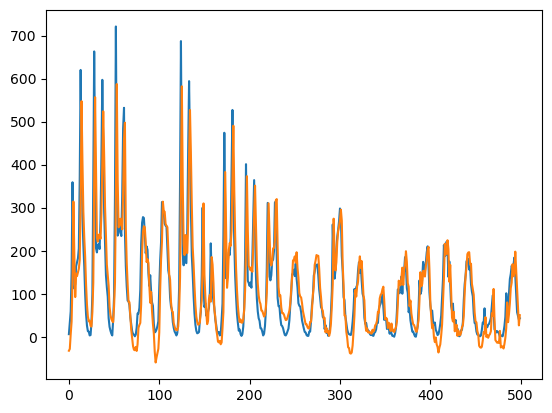

In [34]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual, label="actual")
plt.plot(LSTM_prediction, label="prediction")



But upon taking a closer look, we can see, that the data is mainly just shifted.

Better than the real "shifted" data, but thats someting worth to improve.

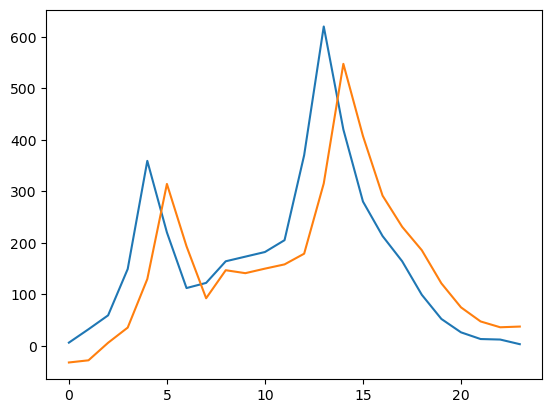

In [35]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual[:24])
plt.plot(LSTM_prediction[:24])




In [36]:
eval_result(LSTM_prediction, LSTM_actual)

Root Mean Squared Error Very Short term: 38.530296325683594
R2 Very Short term: -577.2580620021696

Root Mean Squared Error Short term: 95.51487731933594
R2 Short term: 0.14293781400840788

Root Mean Squared Error Mid term: 102.67971801757812
R2 Mid term: 0.5509189199890403

Root Mean Squared Error Long term: 67.63587188720703
R2 Long term: 0.6541038800438121



Let's try to optimize this with taking more past timeseries datasets into account.

(8236, 24, 4)
(24, 4)
Epoch 1/50
115/115 - 13s - loss: 0.0225 - root_mean_squared_error: 0.1499 - 13s/epoch - 110ms/step
Epoch 2/50
115/115 - 2s - loss: 0.0158 - root_mean_squared_error: 0.1257 - 2s/epoch - 17ms/step
Epoch 3/50
115/115 - 2s - loss: 0.0131 - root_mean_squared_error: 0.1143 - 2s/epoch - 16ms/step
Epoch 4/50
115/115 - 2s - loss: 0.0112 - root_mean_squared_error: 0.1059 - 2s/epoch - 17ms/step
Epoch 5/50
115/115 - 2s - loss: 0.0097 - root_mean_squared_error: 0.0986 - 2s/epoch - 16ms/step
Epoch 6/50
115/115 - 2s - loss: 0.0080 - root_mean_squared_error: 0.0894 - 2s/epoch - 14ms/step
Epoch 7/50
115/115 - 2s - loss: 0.0063 - root_mean_squared_error: 0.0793 - 2s/epoch - 13ms/step
Epoch 8/50
115/115 - 2s - loss: 0.0059 - root_mean_squared_error: 0.0765 - 2s/epoch - 13ms/step
Epoch 9/50
115/115 - 2s - loss: 0.0053 - root_mean_squared_error: 0.0725 - 2s/epoch - 14ms/step
Epoch 10/50
115/115 - 2s - loss: 0.0049 - root_mean_squared_error: 0.0696 - 2s/epoch - 14ms/step
Epoch 11/50
11

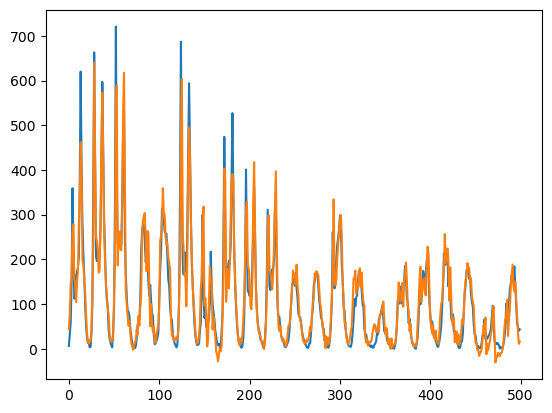

In [37]:
n_hours = 24
n_features = 4

n_obs = n_hours * n_features

reframed_mul = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_mul = reframed_mul.values
train_mul = values_mul[:-500, :]
test_mul = values_mul[-500:, :]

train_X_mul, train_y_mul = train_mul[:, :n_obs], train_mul[:, -n_features]
test_X_mul, test_y_mul = test_mul[:, :n_obs], test_mul[:, -n_features]

train_X_mul = train_X_mul.reshape((train_X_mul.shape[0], n_hours, n_features))
test_X_mul = test_X_mul.reshape((test_X_mul.shape[0], n_hours, n_features))

print(train_X_mul.shape)
print((train_X_mul.shape[1], train_X_mul.shape[2]))

model_mul = create_LSTM_model((train_X_mul.shape[1], train_X_mul.shape[2]))

fit_LSTM_model(model_mul, train_X_mul, train_y_mul, epochs=50)

# make a prediction
LSTM_normalized_prediction_mul = model_mul.predict(test_X_mul)

test_X_mul = test_X_mul.reshape(len(test_X_mul), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_mul, test_X_mul[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_mul.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_mul[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_y)
plt.plot(inv_yhat)




Root Mean Squared Error Very Short term: 37.377349853515625
R2 Very Short term: -4.69022153380892

Root Mean Squared Error Short term: 55.77738952636719
R2 Short term: 0.3420628172654375

Root Mean Squared Error Mid term: 52.03907012939453
R2 Mid term: 0.8870188677298245

Root Mean Squared Error Long term: 41.6324348449707
R2 Long term: 0.8727093445272176



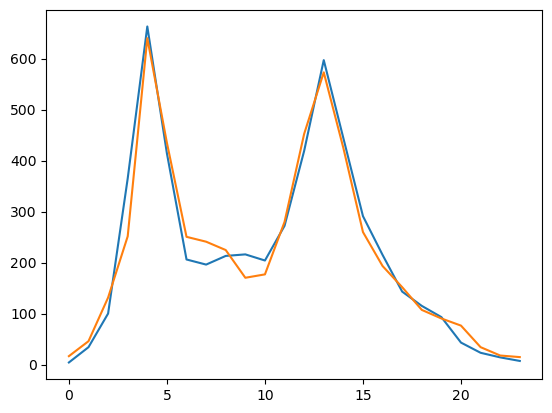

In [38]:
eval_result(inv_yhat, inv_y)

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])




Lets try to optimize it even further with trying to add regularization / additional Layers and additional Epochs into account.

Epoch 1/50
114/114 - 16s - loss: 0.0135 - root_mean_squared_error: 0.1161 - 16s/epoch - 136ms/step
Epoch 2/50
114/114 - 5s - loss: 0.0107 - root_mean_squared_error: 0.1033 - 5s/epoch - 42ms/step
Epoch 3/50
114/114 - 4s - loss: 0.0102 - root_mean_squared_error: 0.1009 - 4s/epoch - 34ms/step
Epoch 4/50
114/114 - 3s - loss: 0.0086 - root_mean_squared_error: 0.0929 - 3s/epoch - 31ms/step
Epoch 5/50
114/114 - 3s - loss: 0.0077 - root_mean_squared_error: 0.0878 - 3s/epoch - 31ms/step
Epoch 6/50
114/114 - 4s - loss: 0.0072 - root_mean_squared_error: 0.0845 - 4s/epoch - 32ms/step
Epoch 7/50
114/114 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0824 - 4s/epoch - 33ms/step
Epoch 8/50
114/114 - 4s - loss: 0.0065 - root_mean_squared_error: 0.0803 - 4s/epoch - 32ms/step
Epoch 9/50
114/114 - 4s - loss: 0.0061 - root_mean_squared_error: 0.0781 - 4s/epoch - 31ms/step
Epoch 10/50
114/114 - 4s - loss: 0.0057 - root_mean_squared_error: 0.0753 - 4s/epoch - 32ms/step
Epoch 11/50
114/114 - 4s - loss: 0.0

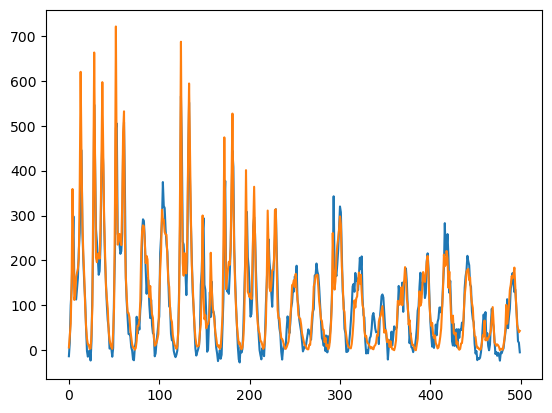

In [39]:

n_hours = 72
n_features = 4

n_obs = n_hours * n_features

reframed_opt = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_opt = reframed_opt.values
train_opt = values_opt[:-500, :]
test_opt = values_opt[-500:, :]

train_X_opt, train_y_opt = train_opt[:, :n_obs], train_opt[:, -n_features]
test_X_opt, test_y_opt = test_opt[:, :n_obs], test_opt[:, -n_features]

train_X_opt = train_X_opt.reshape((train_X_opt.shape[0], n_hours, n_features))
test_X_opt = test_X_opt.reshape((test_X_opt.shape[0], n_hours, n_features))

#Creating a bigger model
model_opt = tf.keras.models.Sequential()
model_opt.add(LSTM(50, input_shape=(train_X_opt.shape[1], train_X_opt.shape[2]), activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))
model_opt.add(Dense(30))
model_opt.add(Dense(20))
model_opt.add(Dense(1))
model_opt.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#print(train_X_opt.shape)
#print(train_y_opt.shape)

fit_LSTM_model(model_opt, train_X_opt, train_y_opt, epochs=50)

# make a prediction
LSTM_normalized_prediction_opt = model_opt.predict(test_X_opt)

test_X_opt = test_X_opt.reshape(len(test_X_opt), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_opt, test_X_opt[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_opt.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_opt[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_yhat)
plt.plot(inv_y)
#print(mean_absolute_error(inv_yhat, inv_y))


eval_result(inv_yhat, inv_y)


In [50]:
eval_result(inv_yhat, inv_y)

Root Mean Squared Error Very Short term: 19.48737335205078
R2 Very Short term: -0.28008574510134165

Root Mean Squared Error Short term: 59.80094528198242
R2 Short term: 0.48744004029961496

Root Mean Squared Error Mid term: 57.31565475463867
R2 Mid term: 0.8387009067553545

Root Mean Squared Error Long term: 44.06355667114258
R2 Long term: 0.8440998367300063



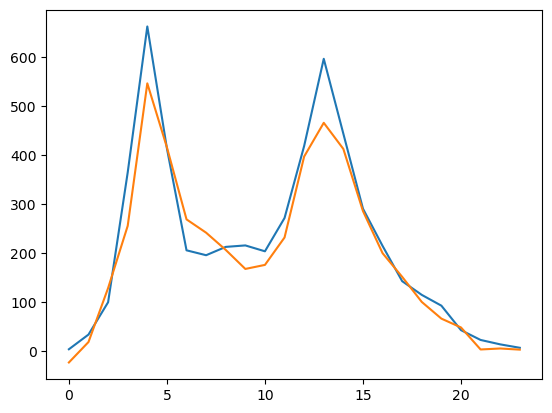

In [40]:

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])





In [51]:
Poly_data = trip_data_website.groupby([
    trip_data_website["start_time"].dt.month, 
    trip_data_website["start_time"].dt.day, 
    trip_data_website["start_time"].dt.weekday, 
    trip_data_website["start_time"].dt.hour,
    trip_data_website["precip"],
    np.floor(trip_data_website["min_temp"])]).size().rename("hourly_demand")#.sample(frac=1)

Poly_data.index.rename(["month", "day", "weekday", "hour", "precip", "min_temp"], inplace=True)
Poly_data = Poly_data.reset_index()

In [47]:
#JD
def create_test_scenarios(poly_degree):
    scaler = StandardScaler()

    months = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["month"].to_frame().to_numpy()))
    weekdays = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["weekday"].to_frame().to_numpy()))
    hours = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["hour"].to_frame().to_numpy()))
    precip = Poly_data["precip"]
    min_temp = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["min_temp"].to_frame().to_numpy()))

    hourly_demand = Poly_data["hourly_demand"].to_frame().to_numpy()

    months_df = pd.DataFrame(months, columns=[f"months_poly_{n}" for n in range(0, len(months[0]))])
    weekdays_df = pd.DataFrame(weekdays, columns=[f"weekdays_{n}" for n in range(0, len(weekdays[0]))])
    hours_df = pd.DataFrame(hours, columns=[f"hours_{n}" for n in range(0, len(hours[0]))])
    precip_df = pd.DataFrame(precip, columns=["precip"])
    min_temp_df = pd.DataFrame(min_temp, columns=[f"min_temp_{n}" for n in range(0, len(min_temp[0]))])
    
    full_data = pd.merge(months_df, weekdays_df, left_index=True, right_index=True)
    full_data = full_data.merge(hours_df, left_index=True, right_index=True)
    full_data = full_data.merge(precip_df, left_index=True, right_index=True)
    
    return full_data.merge(min_temp_df, left_index=True, right_index=True), hourly_demand

# Creates a Regression model with a feature Layer
def prediction_model(feature_layer, num_layers):
    feature_number = len(pd.DataFrame(feature_layer).columns)
    model= tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=feature_number, input_shape=(feature_number,)))
    # Create "num_layer" layers with each one getting smaller by the index of layer (First hidden layer => /2, Second hidden layer => /3, ....)
    [model.add(tf.keras.layers.Dense(units=feature_number//(number_of_layer + 1))) for number_of_layer in range(1, num_layers)]
    model.add(tf.keras.layers.Dense(units=1)) 
    model.compile(optimizer="adam",loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return #JD
def create_test_scenarios(poly_degree):
    scaler = StandardScaler()

    months = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["month"].to_frame().to_numpy()))
    weekdays = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["weekday"].to_frame().to_numpy()))
    hours = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["hour"].to_frame().to_numpy()))
    precip = Poly_data["precip"]
    min_temp = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["min_temp"].to_frame().to_numpy()))

    hourly_demand = Poly_data["hourly_demand"].to_frame().to_numpy()

    months_df = pd.DataFrame(months, columns=[f"months_poly_{n}" for n in range(0, len(months[0]))])
    weekdays_df = pd.DataFrame(weekdays, columns=[f"weekdays_{n}" for n in range(0, len(weekdays[0]))])
    hours_df = pd.DataFrame(hours, columns=[f"hours_{n}" for n in range(0, len(hours[0]))])
    precip_df = pd.DataFrame(precip, columns=["precip"])
    min_temp_df = pd.DataFrame(min_temp, columns=[f"min_temp_{n}" for n in range(0, len(min_temp[0]))])
    
    full_data = pd.merge(months_df, weekdays_df, left_index=True, right_index=True)
    full_data = full_data.merge(hours_df, left_index=True, right_index=True)
    full_data = full_data.merge(precip_df, left_index=True, right_index=True)
    
    return full_data.merge(min_temp_df, left_index=True, right_index=True), hourly_demand

# Creates a Regression model with a feature Layer
def prediction_model(feature_layer, num_layers):
    feature_number = len(pd.DataFrame(feature_layer).columns)
    model= tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=feature_number, input_shape=(feature_number,)))
    # Create "num_layer" layers with each one getting smaller by the index of layer (First hidden layer => /2, Second hidden layer => /3, ....)
    [model.add(tf.keras.layers.Dense(units=feature_number//(number_of_layer + 1))) for number_of_layer in range(1, num_layers)]
    model.add(tf.keras.layers.Dense(units=1)) 
    model.compile(optimizer="adam",loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])
return model 

SyntaxError: invalid non-printable character U+00A0 (819452259.py, line 34)

In [48]:
# Feed a dataset into the model in order to train it.
def train_model(model, X, Y, epochs, batch_size):
    history = model.fit(x=X, y=Y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0)
    epochs = history.epoch
    rmse = pd.DataFrame(history.history)["root_mean_squared_error"]
    return epochs, rmse   

def create_single_model(features, labels, epochs, batch_size, num_layers):
    model = prediction_model(features, num_layers)
    train_model(model, features, labels , epochs, batch_size)
    return model


def eval_model(features, labels, epochs, batch_size, num_layers):
    kfold = KFold(n_splits=10)
    fold_info = []
    for train, test in kfold.split(features, labels):
        print("kfold finished!")
        model = prediction_model(features, num_layers)
        
        train_model(model, features[train], labels[train] , epochs, batch_size)
        
        scores = model.evaluate(features[test], labels[test], verbose=0)
        fold_info.append(scores)
    return pd.DataFrame(fold_info)

In [49]:
LabelEncoder
import tensorflow as tf

Poly_scaler = StandardScaler()

Poly_data_copy = Poly_data.copy()

Poly_data_label = Poly_data_copy.pop("hourly_demand")
Poly_data_features = PolynomialFeatures(degree=5).fit_transform(Poly_scaler.fit_transform(Poly_data_copy))

poly_data_features_low_poly, poly_data_label_low_poly = create_test_scenarios(5)

High_poly_eval = eval_model(Poly_data_features, Poly_data_label, 100, 200, 1)
Low_poly_eval = eval_model(poly_data_features_low_poly.values, poly_data_label_low_poly, 100, 200, 1)

print(High_poly_eval)
print(Low_poly_eval)

print(High_poly_eval.mean()[1])
print(Low_poly_eval.mean()[1])

NameError: name 'create_test_scenarios' is not defined

In [ ]:
model = create_single_model(poly_data_features_low_poly[:-500], poly_data_label_low_poly[:-500], 1000, 200, 1)
poly_predictions = model.predict(poly_data_features_low_poly[-500:])

plt.plot(poly_data_label_low_poly[-500:])
plt.plot(poly_predictions)

eval_result(poly_predictions, poly_data_label_low_poly[-500:])

### Evaluation


In [53]:
Eval = pd.DataFrame (eval_result(inv_yhat, inv_y),eval_result(inv_yhat, inv_y))
Eval.style

Root Mean Squared Error Very Short term: 19.48737335205078
R2 Very Short term: -0.28008574510134165

Root Mean Squared Error Short term: 59.80094528198242
R2 Short term: 0.48744004029961496

Root Mean Squared Error Mid term: 57.31565475463867
R2 Mid term: 0.8387009067553545

Root Mean Squared Error Long term: 44.06355667114258
R2 Long term: 0.8440998367300063

Root Mean Squared Error Very Short term: 19.48737335205078
R2 Very Short term: -0.28008574510134165

Root Mean Squared Error Short term: 59.80094528198242
R2 Short term: 0.48744004029961496

Root Mean Squared Error Mid term: 57.31565475463867
R2 Mid term: 0.8387009067553545

Root Mean Squared Error Long term: 44.06355667114258
R2 Long term: 0.8440998367300063



In [79]:
#Definition RMSE und R2

def RMSE_veryshort(predicted_values, actual_values):
    return(mean_squared_error(predicted_values[:1], actual_values[:1], squared=False))

def RMSE_short(predicted_values, actual_values):  
    return(mean_squared_error(predicted_values[:10], actual_values[:10], squared=False))
    
def RMSE_mid(predicted_values, actual_values):    
    return(mean_squared_error(predicted_values[:100], actual_values[:100], squared=False))

def RMSE_long(predicted_values, actual_values):  
    return(mean_squared_error(predicted_values, actual_values, squared=False))

def R2_veryshort(predicted_values, actual_values):
    return(r2_score(predicted_values[:2], actual_values[:2]))

def R2_short(predicted_values, actual_values):
    return(r2_score(predicted_values[:10], actual_values[:10],))

def R2_mid(predicted_values, actual_values):
    return(r2_score(predicted_values[:100], actual_values[:100]))

def R2_long(predicted_values, actual_values):
    return(r2_score(predicted_values, actual_values))



59.800945

In [87]:
Eval_RMSE = {'Model' : ['LSTM', 'POLY', 'ARIMA'],
'RMSE very short term' : [RMSE_veryshort(inv_yhat, inv_y), RMSE_veryshort(poly_predictions, poly_data_label_low_poly[-500:]), RMSE_veryshort(ARIMA_precip, ARIMA_actual)],
'RMSE short term' : [RMSE_short(inv_yhat, inv_y), RMSE_short(poly_predictions, poly_data_label_low_poly[-500:]), RMSE_short(ARIMA_precip, ARIMA_actual)],
'RMSE mid term' : [RMSE_mid(inv_yhat, inv_y), RMSE_mid(poly_predictions, poly_data_label_low_poly[-500:]), RMSE_mid(ARIMA_precip, ARIMA_actual)],
'RMSE long term' : [RMSE_long(inv_yhat, inv_y), RMSE_long(poly_predictions, poly_data_label_low_poly[-500:]), RMSE_long(ARIMA_precip, ARIMA_actual)]
}

df_eval = pd.DataFrame(Eval_RMSE)
df_eval.style


NameError: name 'poly_predictions' is not defined

In [86]:
Eval_R2 = {'Model' : ['LSTM', 'POLY', 'ARIMA'],
'R2 very short term' : [R2_veryshort(inv_yhat, inv_y), R2_veryshort(poly_predictions, poly_data_label_low_poly[-500:]), R2_veryshort(ARIMA_precip, ARIMA_actual)],
'R2 short term' : [R2_short(inv_yhat, inv_y), R2_short(poly_predictions, poly_data_label_low_poly[-500:]), R2_short(ARIMA_precip, ARIMA_actual)],
'R2 mid term' : [R2_mid(inv_yhat, inv_y), R2_mid(poly_predictions, poly_data_label_low_poly[-500:]), R2_mid(ARIMA_precip, ARIMA_actual)],
'R2 long term' : [R2_long(inv_yhat, inv_y), R2_long(poly_predictions, poly_data_label_low_poly[-500:]), R2_long(ARIMA_precip, ARIMA_actual)]
}

df_eval = pd.DataFrame(Eval_R2)
df_eval.style

,Model,R2 very short term,R2 short term,R2 mid term,R2 long term
0,LSTM,-0.280086,0.487440,0.838701,0.844100
1,POLY,1,1,1,1
2,ARIMA,2,2,2,2
